In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [6]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [7]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, ".")
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [19]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])            # 80% split
Xdev, Ydev = build_dataset(words[n1:n2])        # 10% split
Xte, Yte = build_dataset(words[n2:])            # 10% split


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [23]:
# Torchifying our code :)

class Linear:
    # Just does a matrix mult in the forward pass
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.50
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    # Normalizes each batch using a running mean and var
    # Basically there is a state in this module which introduces lots of bugs
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropegation)
        self.gamma = torch.ones(dim)    # these are Actual trainable params   
        self.beta = torch.zeros(dim)    # these are Actual trainable params
        # buffers (update the running mean of the total to keep model applicable to single examples instead of batches)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True) # batch mean
            xvar = x.var(dim=0, keepdim=True)   # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum) * xmean
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum) * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [24]:
torch.manual_seed(42);

In [26]:
# initializing the neural net

n_embd = 10 # dim of embedding of the character vectors
n_hidden = 200 # the number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embd))
layers =[
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [28]:
# Parameters for training
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.reshape(emb.shape[0], -1)  # concatenate the vectors of the characters
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 1e5 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000: 3.2538
  10000/ 200000: 2.2942
  20000/ 200000: 2.4020
  30000/ 200000: 2.0473
  40000/ 200000: 2.2897
  50000/ 200000: 2.3825
  60000/ 200000: 1.8864
  70000/ 200000: 2.1308
  80000/ 200000: 2.1448
  90000/ 200000: 2.5221
 100000/ 200000: 2.5380
 110000/ 200000: 1.7053
 120000/ 200000: 1.8655
 130000/ 200000: 2.0702
 140000/ 200000: 1.8214
 150000/ 200000: 2.1170
 160000/ 200000: 2.2571
 170000/ 200000: 2.0862
 180000/ 200000: 2.2196
 190000/ 200000: 2.0334


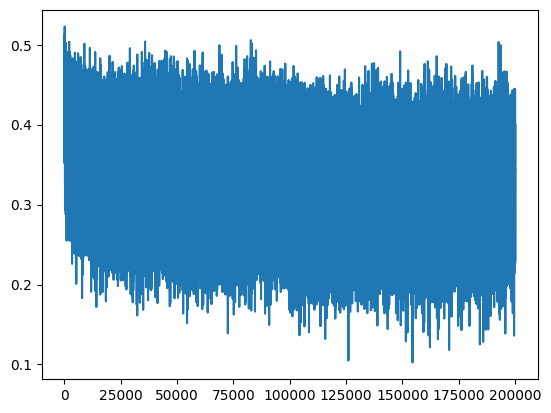

In [29]:
plt.plot(lossi)

In [30]:
for layer in layers:
    layer.training = False

In [31]:
@torch.no_grad()  # A decorator that disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.061959743499756
val 2.1111667156219482


In [32]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

shy.
benzy.
janisa.
fates.
jayden.
liya.
asmikony.
myla.
yoriananseria.
ley.
quinpo.
ball.
wil.
oriana.
azen.
tewali.
azellaya.
rose.
taifi.
istan.
